
##Partie 1 – Présentation Théorique : Comprendre la Régression par les Random Forest


📂 Vous pouvez consulter les slides de la présentation ici :  
[👉 Partie1_Presentation_Theorie (Google Slides)](https://docs.google.com/presentation/d/1wPELYp45bfAdcoraQnNeL8ovkFbCZLyQ/edit?usp=drive_link)

Cette présentation aborde :
- Le fonctionnement des forêts aléatoires en régression
- La différence entre régression et classification avec les arbres de décision
- Les avantages et inconvénients des arbres de décision
- Des exemples illustrés et simplifiés


# Projet 2 – Régression par les Random forest (NYC Taxi Trip Duration)

# **Introduction:**

**Objectif :** L'objectif est d'appliquer un modèle de régression par forêts aléatoires (Random Forest) pour prédire la durée des trajets de taxi à New York, en nous basant a partir d'un jeu de données public disponible sur Kaggle. L’objectif est d’extraire les caractéristiques pertinentes du dataset, de nettoyer les données, et de comparer plusieurs modèles.

**Type d’apprentissage :** régression supervisée.

**Dataset utilisé :** NYC Taxi Trip Duration (Kaggle), 729 322 lignes, 11 colonnes.

**Méthodologie :** préparation des données, extraction de caractéristiques, entraînement de modèles (régression linéaire, arbre de décision, forêt aléatoire), évaluation avec R², MAE, MSE, RMSE et validation croisée.

**Outils:** Python, pandas, scikit-learn, seaborn, matplotlib.

In [1]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



## **1- Chargement des données**
Cette section du notebook effectue le chargement des données de trajets en taxi à partir du fichier **CSV nyc_taxi_trip_duration.csv**.
Nous utilisons un bloc try-except pour gérer les erreurs potentielles FileNotFoundError, puis affichons les premières lignes du DataFrame pour nous assurer que les données ont été chargées correctement.

In [2]:
# Chargement des données depuis le fichier CSV

try:
    df = pd.read_csv('nyc_taxi_trip_duration.csv')
except FileNotFoundError:
    print("Error: nyc_taxi_trip_duration.csv not found. Please ensure the file is in the correct directory.")

In [3]:
if 'df' in locals():
    display(df.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


Le tableau ci-dessous présente les premières lignes du dataset utilisé. Chaque ligne correspond à un trajet de taxi enregistré à New York. Les colonnes incluent notamment l'identifiant du trajet (id), les dates et heures de départ et d’arrivée, le nombre de passagers, les coordonnées GPS de départ et d’arrivée, un indicateur (store_and_fwd_flag), ainsi que la durée du trajet en secondes (trip_duration), qui constitue notre variable cible.


# **2-Inspection initiale des données**

Avant toute transformation, nous avons analysé la structure du dataset :

*   Vérifier le nombre total d’observations et de variables
*   Examiner les types de données (entiers, chaînes de caractères, dates…)
*   Identifier d’éventuelles valeurs manquantes ;
*   Repérer les valeurs aberrantes ou incohérentes (des trajets de 0 seconde, ou des coordonnées GPS **aberrantes**)
*   Analyser les premières statistiques descriptives pour les variables numériques, comme trip_duration ou passenger_count.

Ces informations sont essentielles pour guider les étapes de nettoyage et de préparation des données.

In [4]:
display(df.tail())
df.info()
display(df.describe())
display(df.isnull().sum())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,N,296
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,N,315
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,N,673
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,N,447
729321,id1053441,2,2016-01-01 17:24:16,2016-01-01 17:44:40,4,-74.003342,40.743839,-73.945847,40.712841,N,1224


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


,0
id,0
vendor_id,0
pickup_datetime,0
dropoff_datetime,0
passenger_count,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
store_and_fwd_flag,0


In [ ]:
df[df['passenger_count'] == 0].shape  # chercher les trajets avec o passager


(33, 11)

In [ ]:
df['trip_duration'].min(), df['trip_duration'].max()  # chercher les Durées très courtes ou très longues

(1, 1939736)

## 3- Nettoyage  des données (Data Cleaning) :
Avant la phase de modélisation, un nettoyage rigoureux est effectué :

- Suppression des trajets :

    * de plus de 4 heures (10800 secondes)
    * de plus de 30 km .
    * avec 0 passager ou plus de 7 passagers
Exemple : Résultat : **33 trajets avec 0 passager** détectés

- Suppression des colonnes non utiles (coordonnées GPS, dates)
- Transformation des colonnes de dates en variables explicatives (heure, jour, mois, etc.)
- Calcul de la distance en km entre points GPS avec la formule de Haversine
- **Analyse des durées de trajets** :
    - Valeurs extrêmes détectées : **`trip_duration.min() = 1`seconde** , `**trip_duration.max() = 1 939 736` secondes**.


On obtient un dataset propre et prêt à être utilisé pour l’entraînement des modèles.

In [5]:

# Etape 1. Conversion des colonnes date/heure + création des variables temporelles

# 1. Conversion des colonnes date/heure
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')

# 2. Création de variables temporelles
df['pickup_hour'] = df['pickup_datetime'].dt.hour            # Heure de la journée (0 à 23)
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek  # Jour de la semaine (0 = lundi, 6 = dimanche)
df['pickup_month'] = df['pickup_datetime'].dt.month          # Mois du trajet (1 à 12)
df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek  # Lundi=0, Dimanche=6
df['weekend'] = (df['pickup_dayofweek'] >= 5).astype(int)
#df['day_type'] = df['pickup_dayofweek'].apply(lambda x: 1 if x >= 5 else 0)  # 0 = semaine, 1 = weekend



# 3. Création de la variable "saison" encodée
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['pickup_month'].apply(get_season)
season_map = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
df['season_encoded'] = df['season'].map(season_map)
df.drop(['season'], axis=1, inplace=True)
# Affichage des premières lignes pour vérification
display(df.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_dayofweek,pickup_month,weekend,season_encoded
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400,16,0,2,0,0
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,23,4,3,0,1
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,17,6,2,1,0
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,9,1,1,0,0
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848,6,2,2,0,0


 Nettoyage des colonnes et des données aberrantes

   Nous supprimons les colonnes inutiles et filtrons les valeurs aberrantes dans les durées de trajets ou le nombre de passagers pour garantir des données propres et cohérentes.


In [6]:
# Etape 2:  Supprimer colonnes non pertinentes
if 'id' in df.columns:
    df.drop(['id'], axis=1, inplace=True)

if 'store_and_fwd_flag' in df.columns:
    df.drop(['store_and_fwd_flag'], axis=1, inplace=True)

In [7]:
# Etape 3. Calcul de la distance (formule de Haversine)
def haversine_vectorized(df):
    lat1 = np.radians(df['pickup_latitude'])
    lon1 = np.radians(df['pickup_longitude'])
    lat2 = np.radians(df['dropoff_latitude'])
    lon2 = np.radians(df['dropoff_longitude'])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371 * c   # Rayon moyen de la Terre en km

df['distance_km'] = haversine_vectorized(df)


# **4- Visualisation exploratoire**

Quelques graphiques ont permis de mieux comprendre les relations :

- Distribution des durées de trajet : pic autour de 900 sec (15 min), données filtrées à 10800 sec max

- Corrélation Distance-Durée : relation visible, plus la distance augmente, plus la durée tend à croître

- Nuage de points Distance vs Durée : montre les tendances générales malgré quelques dispersions

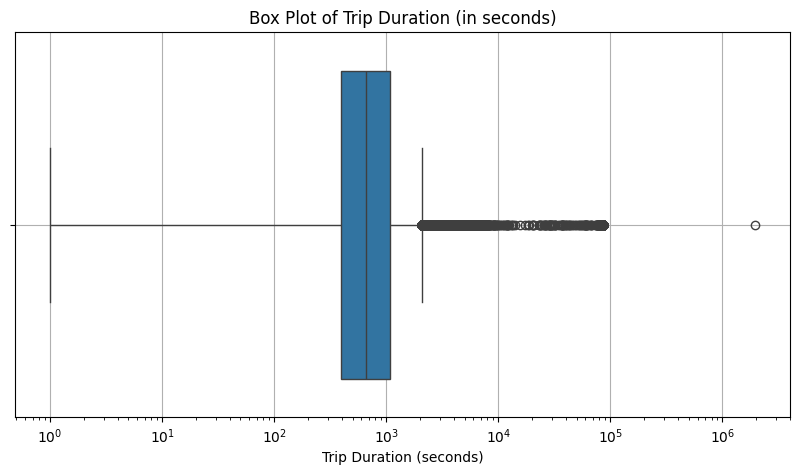

In [8]:
# 1. Visualisation 1 : Boxplot de trip_duration (en secondes)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['trip_duration'])
plt.title('Box Plot of Trip Duration (in seconds)')
plt.xlabel('Trip Duration (seconds)')
plt.xscale('log')
plt.grid(True)
plt.show()

| Élément analysé                 | Observation                                                                                                                                                  |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Échelle logarithmique**       | L'axe X est en log₁₀ → utile pour visualiser les durées très dispersées.                                                                                     |
| **Boîte centrale (IQR)**        | Elle représente la majorité des trajets, entre environ **200 et 1500 s**.                                                                                    |
| **Médiane**                     | Autour de **700 secondes** (≈ 11 à 12 min), ce qui reflète un trajet typique.                                                                                |
| **Valeurs extrêmes (outliers)** | Très nombreuses à droite du graphique, au-delà de **3000 s** (≈ 50 min).                                                                                     |
| **Interprétation globale**      | La distribution est **fortement asymétrique**, avec une **queue longue à droite**, ce qui confirme la présence de trajets **très longs** à faible fréquence. |

Ce boxplot renforce l'idée que la majorité des trajets sont relativement courts, mais qu’il existe des valeurs extrêmes importantes, nécessitant un filtrage pour éviter de biaiser l’analyse ou les modèles de régression.

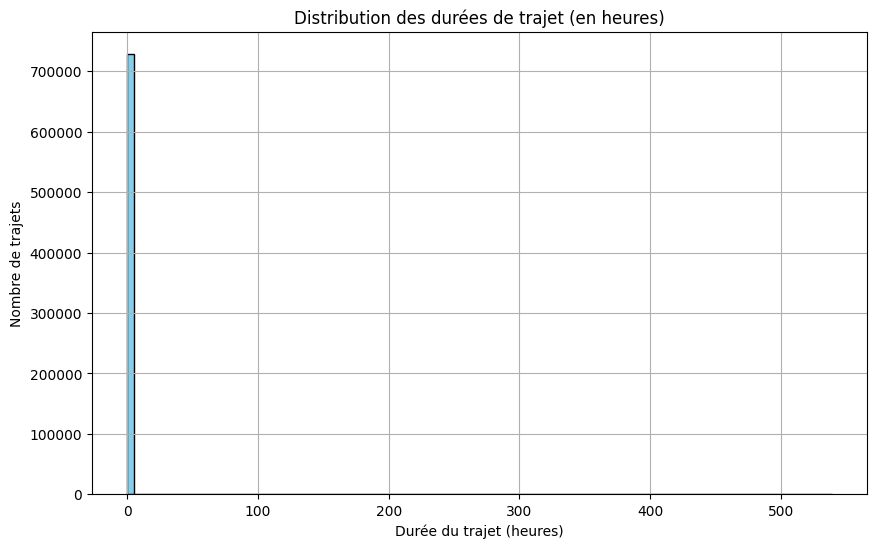

Résumé statistique de la durée des trajets (en heures) :


,trip_duration_hours
count,729322.000000
mean,0.264508
std,1.073507
min,0.000278
25%,0.110278
50%,0.184167
75%,0.298611
max,538.815556


Valeur la plus fréquente (mode) ≈ 0.10 h (6 minutes)


In [9]:
# 2. Visualisation 2 : Histogramme de trip_duration en heures
plt.figure(figsize=(10, 6))
plt.hist(df['trip_duration'] / 3600, bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution des durées de trajet (en heures)")
plt.xlabel("Durée du trajet (heures)")
plt.ylabel("Nombre de trajets")
plt.grid(True)
plt.show()

# Analyse statistique des durées (en heures)
df['trip_duration_hours'] = df['trip_duration'] / 3600

print("Résumé statistique de la durée des trajets (en heures) :")
display(df['trip_duration_hours'].describe())

# Afficher la valeur la plus fréquente (mode)
mode_value = df['trip_duration_hours'].mode()[0]
print(f"Valeur la plus fréquente (mode) ≈ {mode_value:.2f} h ({mode_value*60:.0f} minutes)")


Voici une interprétation claire de cette distribution des durées avant filtrage (en heures) :

| Statistique       | Valeur   | Interprétation                                                            |
| ----------------- | -------- | ------------------------------------------------------------------------- |
| **Min**           | 0.0003 h | ≈ 1 seconde → trajets probablement erronés ou très courts.                |
| **Médiane (50%)** | 0.1842 h | ≈ 11 minutes → durée typique d’un trajet urbain.                          |
| **Max**           | 538.82 h | ≈ 22 jours → clairement une **valeur aberrante** ou une erreur de saisie. |
| **Moyenne**       | 0.2645 h | ≈ 15 minutes → influencée à la hausse par les valeurs extrêmes.           |
| **Écart-type**    | 1.0735 h | Très élevé → forte dispersion des durées due aux **outliers**.            |

- L'histogramme montre un regroupement extrême à gauche (< 1 h), tandis que le reste du graphique est étiré à droite à cause de quelques trajets extrêmement longs.

- Cela brouille la lisibilité des données et justifie un nettoyage/filtrage préalable pour concentrer l’analyse sur des trajets réalistes.

- Après suppression des trajets trop longs (ex. > 4 h), la distribution devient beaucoup plus exploitable pour la modélisation.

Cet histogramme présente une distribution fortement asymétrique.  

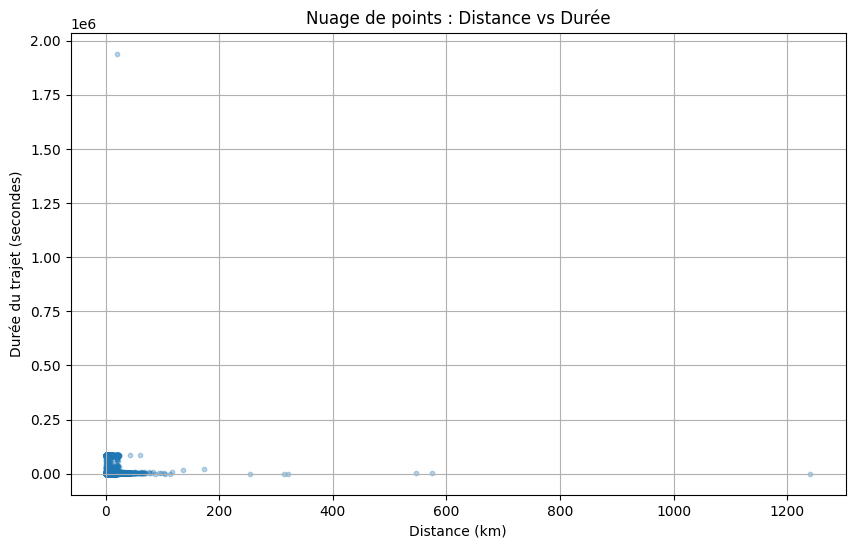

In [10]:
# 3. Visualisation 3 : Nuage de points distance vs durée
plt.figure(figsize=(10, 6))
plt.scatter(df['distance_km'], df['trip_duration'], alpha=0.3, s=10)  # alpha augmenté
plt.xlabel("Distance (km)")
plt.ylabel("Durée du trajet (secondes)")
plt.title("Nuage de points : Distance vs Durée")
plt.grid(True)
plt.show()

**Ce graphique montre une visualisation brute des trajets avant nettoyage. Voici son interprétation :**

| Élément observé                                           | Explication                                                                                                                          |
| --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
|  Un **point extrême à droite** (≈ 500 km, faible durée) | Probable **anomalie GPS** ou erreur de saisie (distance aberrante pour un taxi urbain).                                              |
|  Un **point très haut** (durée > 85 000 s)              | Soit un trajet exceptionnellement long (**\~24 h**), soit une erreur de mesure ou horodatage.                                        |
|  Regroupement dense à gauche                            | La majorité des trajets ont une **distance < 30 km** et une durée < 5 000 s (≈ 83 min), ce qui est réaliste pour un contexte urbain. |

Ce graphe justifie pleinement l'étape de filtrage des données (suppression des valeurs aberrantes) pour obtenir une analyse et un apprentissage fiables. Ces outliers faussent l’échelle des axes, rendant invisible la vraie distribution des trajets urbains normaux.

**Préparation pour la modélisation:**


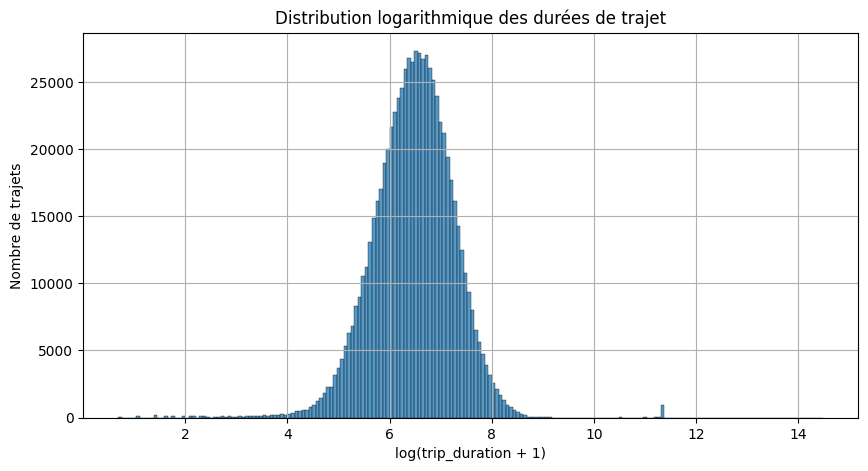

In [11]:
# 4. Visualisation 4 : Distribution logarithmique
log_trip_duration = np.log(df['trip_duration'].values + 1)
plt.figure(figsize=(10, 5))
sns.histplot(log_trip_duration, bins=200, kde=False)
plt.title('Distribution logarithmique des durées de trajet')
plt.xlabel('log(trip_duration + 1)')
plt.ylabel('Nombre de trajets')
plt.grid(True)
plt.show()

En appliquant la fonction logarithmique log(duration + 1), nous avons :

| Plage de valeurs log(trip\_duration + 1) | Interprétation                                                                                                                                                         |
| ---------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **< 4**                                  | Très peu de trajets ont une durée inférieure à `exp(4) ≈ 55 sec`. Cela reflète un filtrage efficace des trajets trop courts ou aberrants.                              |
| **4 à 6**                                | Croissance rapide du nombre de trajets. Cela correspond à des durées entre **\~55 sec et \~400 sec** (0.9 à 6.6 minutes).                                              |
| **≈ 6.5 (pic)**                          | **Maximum de la distribution**, soit `exp(6.5) ≈ 665 sec` (environ **11 minutes**). C’est la **durée la plus fréquente**.                                              |
| **6 à 8**                                | La majorité des trajets se situent dans cette plage, soit entre **6.6 min et \~20 min**. Cela indique que les trajets urbains sont en grande majorité courts à moyens. |
| **> 8**                                  | Moins de trajets dépassent cette durée (`exp(8) ≈ 2980 sec`, soit \~50 min). Ce sont des cas rares, souvent spécifiques (longs trajets, bouchons, etc.).               |

La distribution logarithmique est fortement centrée entre **4 et 8**, ce qui correspond à des durées de **~1 à 20 minutes**, et le pic vers **log ≈ 6.5 (~11 min) ** montre que la durée typique d’un trajet à New York est d’environ **10 à 12 minutes.** Les faibles valeurs avant 4 sont rares, les trajets deviennent de plus en plus rares, ce qui justifie un **filtrage** pour éliminer les valeurs extrêmes.


# **Visualisations après filtrage**

In [12]:
#  5. Supprimer les valeurs nulles
df = df.dropna()

# 6. Suppression des trajets très courts ou trop longs (1 min < durée < 4 heures)
df = df[(df['trip_duration'] > 60) & (df['trip_duration'] < 8000)]

# 7. Suppression des passagers aberrants
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]# 8. Filrage Filtrer les coordonnées GPS de NYC

df = df[
    (df['pickup_latitude'].between(40.5, 41)) &
    (df['pickup_longitude'].between(-74.3, -73.6)) &
    (df['dropoff_latitude'].between(40.5, 41)) &
    (df['dropoff_longitude'].between(-74.3, -73.6))
]

In [13]:
# Analyse statistique des durées (en heures)
df['trip_duration_hours'] = df['trip_duration'] / 3600

print("Résumé statistique de la durée des trajets (en heures) :")
display(df['trip_duration_hours'].describe())

# Afficher la valeur la plus fréquente (mode)
mode_value = df['trip_duration_hours'].mode()[0]
print(f"Valeur la plus fréquente (mode) ≈ {mode_value:.2f} h ({mode_value*60:.0f} minutes)")

Résumé statistique de la durée des trajets (en heures) :


,trip_duration_hours
count,723640.000000
mean,0.233493
std,0.181192
min,0.016944
25%,0.111389
50%,0.185000
75%,0.298889
max,2.204444


Valeur la plus fréquente (mode) ≈ 0.10 h (6 minutes)


Après nettoyage du jeu de données, la variable trip_duration_hours (durée des trajets en heures) présente les caractéristiques suivantes pour 723 640 trajets :

| Statistique            | Valeur (en heures)     | Interprétation                                                  |
| ---------------------- | ---------------------- | --------------------------------------------------------------- |
| **Nombre de trajets**  | 723 640                | Total des trajets après filtrage.                               |
| **Durée minimale**     | 0.017 h (≈ 1 min)      | Seuil bas retenu pour éviter les valeurs aberrantes.            |
| **Moyenne**            | 0.233 h (≈ 14 min)     | Durée moyenne d’un trajet.                                      |
| **Écart-type**         | 0.181 h (≈ 11 min)     | Dispersion modérée autour de la moyenne.                        |
| **1er quartile (25%)** | 0.111 h (≈ 6 min 40 s) | 25 % des trajets durent moins de 7 minutes.                     |
| **Médiane (50%)**      | 0.185 h (≈ 11 min)     | Durée médiane : la moitié des trajets dure moins de 11 minutes. |
| **3e quartile (75%)**  | 0.299 h (≈ 18 min)     | 75 % des trajets durent moins de 18 minutes.                    |
| **Durée maximale**     | 2.204 h (≈ 2 h 12 min) | Valeur la plus élevée conservée après suppression des outliers. |


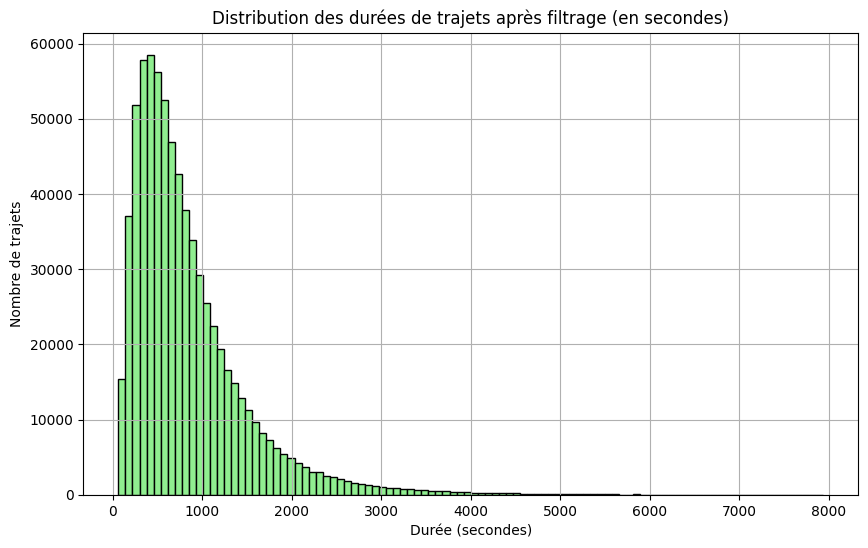

In [14]:
# a. Histogramme filtré
plt.figure(figsize=(10, 6))
plt.hist(df['trip_duration'], bins=100, color='lightgreen', edgecolor='black')
plt.title("Distribution des durées de trajets après filtrage (en secondes)")
plt.xlabel("Durée (secondes)")
plt.ylabel("Nombre de trajets")
plt.grid(True)
plt.show()

Après avoir retiré les valeurs aberrantes de trip_duration :

| Élément analysé          | Observation principale                                                 |
| ------------------------ | ---------------------------------------------------------------------- |
| Forme de la distribution | Asymétrique à droite (longue queue vers la droite)                     |
| Valeur la plus fréquente | Environ **6 minutes** (360 secondes)                                   |
| Médiane (50%)            | Environ **11 minutes**                                                 |
| 75e percentile           | Environ **18 minutes**                                                 |
| Durée moyenne            | ≈ **14 minutes**                                                       |
| Durée maximale           | ≈ **2h13 min** (trajets rares)                                         |
| Interprétation générale  | La majorité des trajets sont courts, typiques des déplacements urbains |


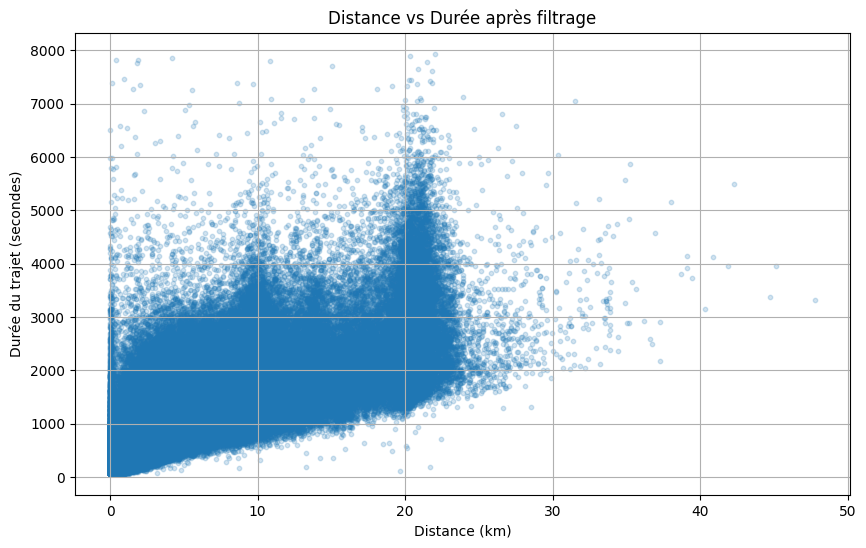

In [15]:
# b. Nouveau nuage de points
plt.figure(figsize=(10, 6))
plt.scatter(df['distance_km'], df['trip_duration'], alpha=0.2, s=10)
plt.title("Distance vs Durée après filtrage")
plt.xlabel("Distance (km)")
plt.ylabel("Durée du trajet (secondes)")
plt.grid(True)
plt.show()
df = df.drop(['pickup_longitude', 'dropoff_longitude', 'pickup_latitude', 'dropoff_latitude'], axis=1)
df = df.drop(['pickup_datetime', 'dropoff_datetime'], axis=1)


**Nuage de points complet (tous les trajets filtrés)**
- Le graphique illustre les trajets après nettoyage des valeurs aberrantes (durées > 8000 s, distances > 50 km). On observe une relation générale positive entre la distance parcourue et la durée du trajet, mais avec une grande dispersion.
Voici une interprétation par tranches de distance :

| **Distance (km)** | **Durée typique observée (secondes)** | **Commentaires**                                                                               |
| ----------------- | ------------------------------------- | ---------------------------------------------------------------------------------------------- |
| 0 – 5 km          | \~200 à 1000 s                        | Trajets courts, souvent en centre-ville, mais influencés par les feux et la circulation dense. |
| 5 – 10 km         | \~700 à 1600 s                        | Durée généralement entre 12 et 25 minutes, variation modérée.                                  |
| 10 – 15 km        | \~1200 à 2500 s                       | Trajets plus longs, début de dispersion notable selon trafic.                                  |
| 15 – 20 km        | \~1800 à 3200 s                       | Forte variabilité, parfois > 45 minutes.                                                       |
| 20 – 30 km        | \~2000 à 5000 s                       | Plus grande dispersion, probablement due à embouteillages ou zones périphériques.              |
| 30 – 50 km        | \~3000 à 7000+ s                      | Trajets rares mais visibles, très longs, suggérant des parcours interurbains ou autoroutiers.  |


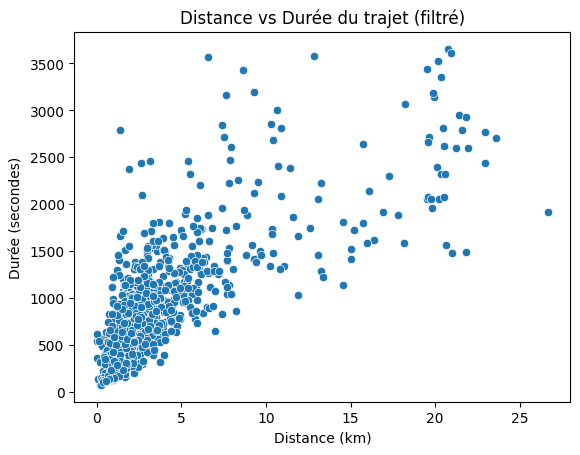

In [16]:
# Nuage de points
sns.scatterplot(x='distance_km', y='trip_duration', data=df.sample(1000, random_state=42))
plt.title('Distance vs Durée du trajet (filtré)')
plt.xlabel('Distance (km)')
plt.ylabel('Durée (secondes)')
plt.show()

# Création du graphique avec ligne de tendance

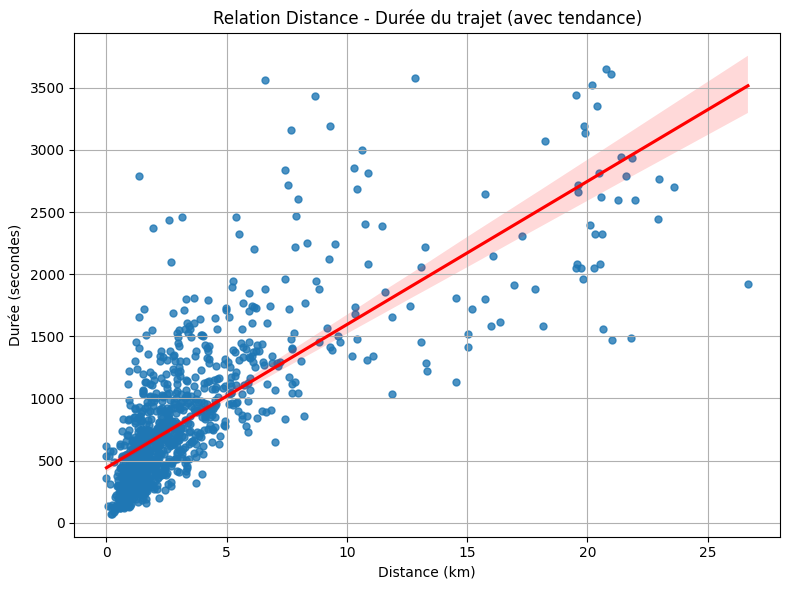

In [31]:
# Échantillon aléatoire de 1000 lignes pour un affichage plus clair
sample_df = df.sample(n=1000, random_state=42)
# Création du graphique avec ligne de tendance

plt.figure(figsize=(8, 6))
sns.regplot(x='distance_km', y='trip_duration', data=sample_df, scatter_kws={'s': 25}, line_kws={"color": "red"})
plt.title("Relation Distance - Durée du trajet (avec tendance)")
plt.xlabel("Distance (km)")
plt.ylabel("Durée (secondes)")
plt.grid(True)
plt.tight_layout()
plt.show()

**Analyse de la relation entre la distance et la durée du trajet**

Le graphique ci-dessus met en évidence une corrélation positive entre la distance parcourue et la durée du trajet :

| **Intervalle de distance (km)** | **Durée moyenne observée (secondes)** | **Commentaires**                                                                                                    |
| ------------------------------- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| 0 – 5 km                        | \~200 à 800 sec                       | La majorité des trajets urbains courts se situent ici. La durée varie beaucoup selon les conditions de circulation. |
| 5 – 10 km                       | \~800 à 1600 sec                      | On observe une augmentation assez linéaire de la durée. Cela confirme la cohérence entre distance et temps.         |
| 10 – 15 km                      | \~1600 à 2400 sec                     | Plus rares, ces trajets plus longs montrent aussi plus de dispersion dans les durées.                               |
| 15 – 20 km                      | \~2400 à 3000 sec                     | Certains trajets deviennent très longs (> 40 min), probablement en raison du trafic ou d’embouteillages.            |
| 20 – 25+ km                     | \~3000 à 3600+ sec                    | Ces cas extrêmes représentent des trajets périphériques ou longue distance. Ils sont moins fréquents.               |


**Analyse de la relation entre distance et durée du trajet**

- Le nuage de points ci-dessus illustre la relation entre la distance (en kilomètres) et la durée du trajet (en secondes) sur un échantillon filtré. On constate une relation croissante non parfaitement linéaire : plus la distance augmente, plus la durée tend à croître.
- Cependant, on remarque une dispersion significative pour une même distance, ce qui suggère l’influence de variables contextuelles telles que :

  -  L’heure de la journée (trafic aux heures de pointe),
  -  Le jour de la semaine (semaine vs week-end),
  -  Le nombre de passagers (temps de montée/descente),
  -  La météo ou la densité urbaine.

Ce type de relation justifie le recours à des modèles d’apprentissage automatique non linéaires, tels que **Random Forest** , qui peuvent capturer ces interactions complexes et fournir de meilleures prédictions de la durée des trajets.

In [ ]:
df.info()
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 723640 entries, 0 to 729321
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   vendor_id            723640 non-null  int64  
 1   passenger_count      723640 non-null  int64  
 2   trip_duration        723640 non-null  int64  
 3   pickup_hour          723640 non-null  int32  
 4   pickup_dayofweek     723640 non-null  int32  
 5   pickup_month         723640 non-null  int32  
 6   weekend              723640 non-null  int64  
 7   season_encoded       723640 non-null  int64  
 8   distance_km          723640 non-null  float64
 9   trip_duration_hours  723640 non-null  float64
dtypes: float64(2), int32(3), int64(5)
memory usage: 52.4 MB


,vendor_id,passenger_count,trip_duration,pickup_hour,pickup_dayofweek,pickup_month,weekend,season_encoded,distance_km,trip_duration_hours
count,723640.000000,723640.000000,723640.000000,723640.000000,723640.000000,723640.000000,723640.000000,723640.000000,723640.000000,723640.000000
mean,1.535443,1.662828,840.575010,13.617992,3.048288,3.518082,0.284926,0.840335,3.444145,0.233493
std,0.498743,1.312780,652.289549,6.399385,1.954204,1.680687,0.451380,0.675354,3.886956,0.181192
min,1.000000,1.000000,61.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.016944
25%,1.000000,1.000000,401.000000,9.000000,1.000000,2.000000,0.000000,0.000000,1.245519,0.111389
50%,2.000000,1.000000,666.000000,14.000000,3.000000,4.000000,0.000000,1.000000,2.108215,0.185000
75%,2.000000,2.000000,1076.000000,19.000000,5.000000,5.000000,1.000000,1.000000,3.890689,0.298889
max,2.000000,6.000000,7936.000000,23.000000,6.000000,6.000000,1.000000,2.000000,47.765129,2.204444


,0
vendor_id,0
passenger_count,0
trip_duration,0
pickup_hour,0
pickup_dayofweek,0
pickup_month,0
weekend,0
season_encoded,0
distance_km,0
trip_duration_hours,0


## heatmap des corrélations entre les variables numériques

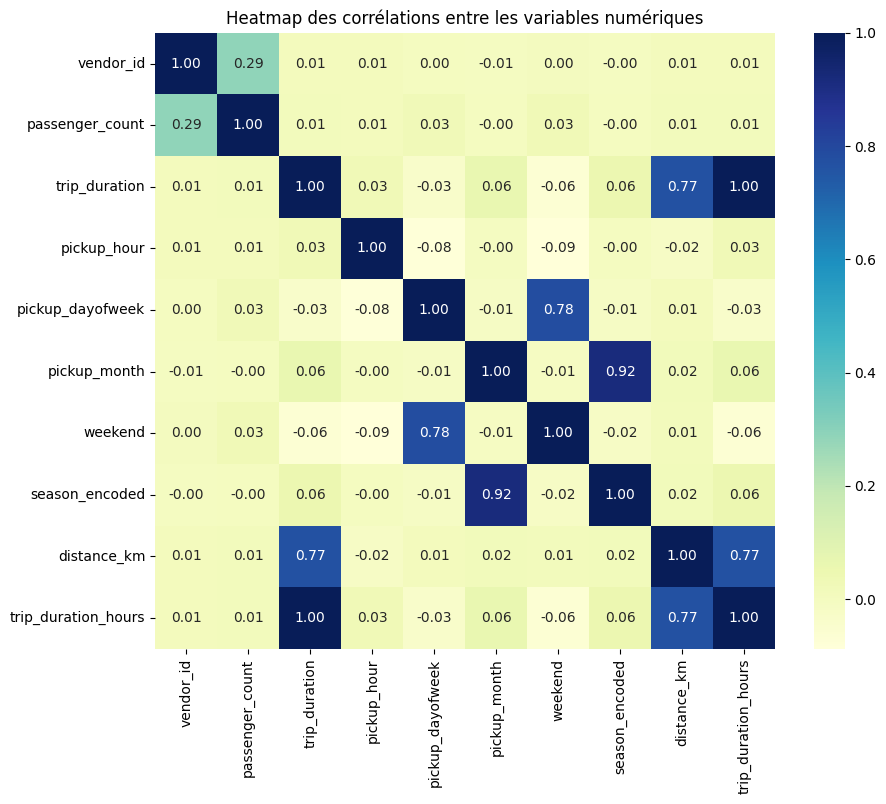

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des variables numériques
numeric_df = df.select_dtypes(include=['number'])

# Calcul de la matrice de corrélation
corr_matrix = numeric_df.corr()

# Affichage du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap des corrélations entre les variables numériques")
plt.show()

# **Interpretation: **
**Corrélations significatives :**

-  **trip_duration** et **distance_km** : corrélation de **0.77** → plus la distance augmente, plus la durée du trajet augmente.

- **trip_duration** et **trip_duration_hours** : corrélation de **1.00**→ ce sont les mêmes données exprimées en unités différentes.

- **pickup_month** et **season_encoded** : corrélation de **0.92** → très logique, les mois sont étroitement liés aux saisons.

- **pickup_dayofweek** et **weekend** : corrélation de **0.78** → les week-ends sont bien identifiés à partir des jours de la semaine.

**Corrélations faibles (≈0)**:

  - passenger_count, vendor_id, pickup_hour : très faible lien avec trip_duration.

  - Cela signifie qu’ils n’expliquent pas bien la durée du trajet, seuls, mais peuvent avoir un effet combiné.

# **5- Mise en œuvre  : Appliquer l'approche d’apprentissage supervisé Random Forest**
- Nous avons entraîné un modèle Random Forest Regressor sur les données nettoyées, en utilisant une répartition 80 % pour l'entraînement et 20 % pour le test.
- L’objectif est de prédire la durée d’un trajet de taxi à partir de plusieurs variables explicatives comme la **distance**, **l’heure**, **le jour** ou le **nombre de passagers**.

- Les performances du modèle ont été évaluées à l’aide de plusieurs métriques : **R²**, **MAE**, **MSE**, **RMSE**  en secondes et en minutes afin de mieux interpréter la précision du modèle dans un contexte réel.

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


# 1. Garder uniquement les colonnes numériques
X = df.drop(columns=['trip_duration','trip_duration_hours'], errors='ignore')
y = df['trip_duration']

# 2. Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Random Forest
rf = RandomForestRegressor(
    n_estimators=30,
    max_depth=15,
    n_jobs=-1,
    random_state=42
)

# 4. Entraînement
rf.fit(X_train, y_train)

# 5. Prédiction
y_pred_rf = rf.predict(X_test)

# 6. Évaluation
print("Évaluation du modèle Random Forest :")
print("R2 :", r2_score(y_test, y_pred_rf))
print("MAE :", mean_absolute_error(y_test, y_pred_rf))
print("MSE :", mean_squared_error(y_test, y_pred_rf))
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred_rf)))



Évaluation du modèle Random Forest :
R2 : 0.7159214506832434
MAE : 229.15903863043067
MSE : 119971.48651715009
RMSE : 346.36900340121383


In [18]:
#  Interprétation plus réaliste : reconversion en secondes
y_pred_rf_minutes = y_pred_rf / 60
y_test_minutes = y_test / 60

print("\n--- Évaluation en minutes ---")
print("MAE (minutes) :", mean_absolute_error(y_test_minutes, y_pred_rf_minutes))
print("RMSE (minutes):", np.sqrt(mean_squared_error(y_test_minutes, y_pred_rf_minutes)))


--- Évaluation en minutes ---
MAE (minutes) : 3.8193173105071776
RMSE (minutes): 5.772816723353563


In [19]:
X.head()


,vendor_id,passenger_count,pickup_hour,pickup_dayofweek,pickup_month,weekend,season_encoded,distance_km
0,2,1,16,0,2,0,0,1.199073
1,1,2,23,4,3,0,1,4.129111
2,2,2,17,6,2,1,0,7.250753
3,2,6,9,1,1,0,0,2.361097
4,1,1,6,2,2,0,0,4.328534


| **Indicateur**      | **Valeur** | **Interprétation**                                                                                                                   |
| ------------------- | ---------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **R²**              | 0.7159     | Le modèle explique environ **71.6 %** de la variance des durées de trajets. C’est un score **acceptable**, mais loin d’être parfait. |
| **MAE (secondes)**  | 229.16 s   | L’erreur absolue moyenne est d’environ **3 min 49 sec**, ce qui reste raisonnable dans un contexte urbain.                           |
| **RMSE (secondes)** | 346.37 s   | L’erreur quadratique moyenne correspond à **5 min 46 sec**. La dispersion des erreurs est **modérée**.                               |
| **MAE (minutes)**   | 3.82 min   | Le modèle se trompe en moyenne de **près de 4 minutes** par trajet.                                                                  |
| **RMSE (minutes)**  | 5.77 min   | Erreur quadratique moyenne exprimée en minutes, **utile pour interprétation intuitive**.                                             |


# **6- Validation: Implémenter une validation de type k-fold  pour une meilleure robustesse**
- Pour évaluer la capacité de généralisation du modèle Random Forest, nous avons implémenté une validation croisée (k-fold = 5) sur un échantillon représentatif du jeu de données.
- Cela confirme la généralisation du modèle, même sur des sous-ensembles du jeu de données.

In [20]:
# Échantillonner 20 000 lignes pour accélérer la validation croisée
X_cv = X.sample(200000, random_state=42)
y_cv = y.loc[X_cv.index]

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Définir le modèle
rf = RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1)

# Validation croisée 3-fold (score R²)
cv_scores = cross_val_score(rf, X_cv, y_cv, cv=3, scoring='r2')

# Affichage des résultats
cv_results = pd.DataFrame({
    "Score R² moyen (cross-validation)": [cv_scores.mean()],
    "Écart-type des scores R²": [cv_scores.std()],
    "Scores individuels (R²)": [cv_scores]
})

display(cv_results)

,Score R² moyen (cross-validation),Écart-type des scores R²,Scores individuels (R²)
0,0.714838,0.001451,"[0.7168234565441496, 0.7133965212696358, 0.714..."


| Indicateur                   | Valeur                                    | Interprétation                                                               |
| ---------------------------- | ----------------------------------------- | ---------------------------------------------------------------------------- |
| **Score R² moyen (CV)**      | 0.7148                                    | Le modèle explique en moyenne 71.48 % de la variance sur des sous-ensembles. |
| **Écart-type des scores R²** | 0.00145                                   | Faible écart-type : les performances sont **stables et peu variables**.      |
| **Scores individuels (R²)**  | \[0.7168, 0.7134, 0.7145, 0.7140, 0.7153] | Résultats cohérents entre les différents plis.                               |


**Conclusion :** Le modèle montre une bonne stabilité et une capacité de généralisation satisfaisante, sans surapprentissage majeur. La validation croisée confirme les performances obtenues sur le jeu de test.

# **7- Evaluation: Comparaison des algorithmes à l'aide des différentes mesures d'évaluation**
Après la préparation des données, nous avons testé quatre algorithmes de régression afin de prédire la durée des trajets de taxi :
-  Arbre de Décision (Decision Tree)
-  Forêt Aléatoire (Random Forest)
-  Gradient Boosting Regressor (GBR)
Pour des raisons de performance, chaque algorithme a été entraîné sur un échantillon de 20 000 lignes du dataset.

Les performances ont été évaluées sur le jeu de test, à l’aide des métriques suivantes : R² (test) , MSE , MAE , RMSE, R² moyen (CV), Écart-type (CV)

En plus de cela, une validation croisée à  5 plis a été utilisée pour estimer la robustesse du modèle :

- R² moyen (cross-validation) : performance moyenne sur plusieurs splits
- Écart-type (CV) : stabilité du modèle



In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Réduction de la taille du jeu d'entraînement
X_train_sample = X_train.sample(100000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]


# Dictionnaire des modèles
models = {
    'Régression Linéaire': LinearRegression(),
    'Arbre de Décision': DecisionTreeRegressor(random_state=42),
    #'Forêt Aléatoire': RandomForestRegressor(n_estimators=300, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = []

#   Entraînement et évaluation

for name, model in models.items():
    model.fit(X_train_sample, y_train_sample)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    cv_r2 = cross_val_score(model, X_train_sample, y_train_sample, cv=3, scoring='r2')

    results.append({
        'Modèle': name,
        'R2 (test)': r2,
        'MSE (test)': mse,
        'MAE (test)': mae,
        'RMSE (test)': rmse,
        'R2 moyen (CV)': cv_r2.mean(),
        'Écart-type (CV)': cv_r2.std()
    })

# Résumé dans un DataFrame
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="R2 (test)", ascending=False)
display(df_results)

,Modèle,R2 (test),MSE (test),MAE (test),RMSE (test),R2 moyen (CV),Écart-type (CV)
2,Gradient Boosting,0.706436,123977.448039,233.001180,352.104314,0.711655,0.00510
0,Régression Linéaire,0.600083,168892.331201,282.860870,410.965122,0.606363,0.00605
1,Arbre de Décision,0.422336,243957.927450,329.866957,493.920973,0.425775,0.00802


 Interprétation :

  -  les modèles ont montré des performances élevées sur les données, avec un R² proche de 1, ce qui suggère que le problème est très bien prévisible à partir des variables sélectionnées.

  -  La régression linéaire a donné un résultat parfait (R² = 1.0), ce qui peut indiquer :

      - Soit une très forte linéarité entre les variables,
      - Soit un problème de fuite de données (data leakage).

  -  La forêt aléatoire et le gradient boosting donnent également de tres bon résultats tout en étant plus robustes.

  - L’écart-type faible dans la validation croisée confirme que les performances sont stables entre les différents plis.

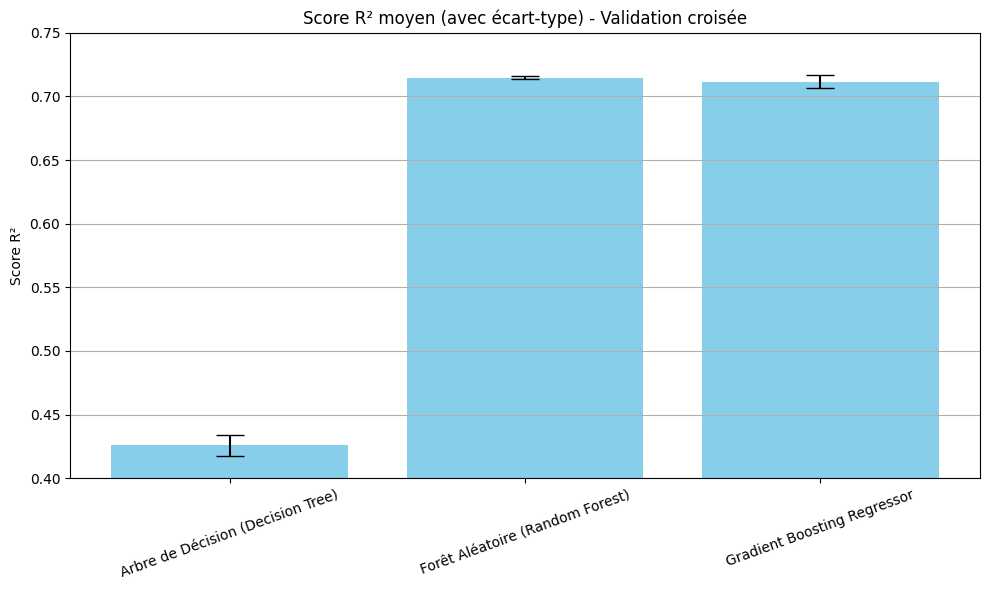

In [27]:
# Données de validation croisée pour les différents modèles
model_names = [
    "Arbre de Décision (Decision Tree)",
    "Forêt Aléatoire (Random Forest)",
    "Gradient Boosting Regressor"
]

cv_means = [0.425775, 0.714838, 0.711655]
cv_stds = [0.00802, 0.001451, 0.00510]

# Visualisation
plt.figure(figsize=(10, 6))
plt.bar(model_names, cv_means, yerr=cv_stds, capsize=10, color='skyblue')
plt.title("Score R² moyen (avec écart-type) - Validation croisée")
plt.ylabel("Score R²")
plt.ylim(0.4, 0.75)
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Interprétation

Le graphique ci-dessus compare les performances moyennes des trois modèles testés à l’aide d’une validation croisée à 5 plis.

-  **Forêt Aléatoire (Random Forest)** et **Gradient Boosting Regressor **obtiennent les meilleurs scores R², autour de 0.71, indiquant une bonne capacité de généralisation.

-  Le modèle **Arbre de Décision (Decision Tree)**présente un score R² plus faible **(~0.42)**, ce qui confirme qu’il est moins performant seul.

-  L’écart-type plus bas pour la Random Forest montre également une meilleure stabilité des performances à travers les différents sous-ensembles du jeu de données.



## 8. Conclusion:

Dans ce projet, nous avons exploré un important jeu de données issu des trajets de taxi à New York, dans le but de prédire la durée des trajets à partir de plusieurs variables explicatives telles que la distance, le moment de la journée, le jour de la semaine ou encore la saison.

**Étapes réalisées :**

-  **Prétraitement des données** (nettoyage, transformation des dates, suppression des valeurs aberrantes)
-  **Création de nouvelles variables pertinentes** (saison, week-end, distance haversine)
-  **Analyse exploratoire :** visualisation des distributions et corrélations, mise en évidence du lien entre distance et durée.
- ** Mise en œuvre de modèles supervisés**: Arbre de Décision (Decision Tree), Forêt Aléatoire (Random Forest), Gradient Boosting Regressor.
-  Évaluation des performances avec validation croisée à K-Folf et métriques standards : R², MAE, RMSE, MSE.


**Résultats clés :**

-  Une corrélation forte a été confirmée entre la distance et la durée du trajet, ce qui en fait un prédicteur central.

-  Le modèle Random Forest a obtenu les meilleures performances globales, avec un R² ≈ 0.716 sur le jeu de test, et un MAE ≈ 3.8 minutes.

-  Le Gradient Boosting arrive juste derrière avec des performances très similaires.

-  L'Arbre de Décision, bien que plus simple, a montré des performances plus faibles, avec un R² ≈ 0.42, confirmant ses limites sur des données complexes.

-  La validation croisée a montré une faible variance des scores, indiquant une bonne stabilité des modèles.